# Preserving global structure

In [1]:
import gzip
import pickle

import numpy as np
import openTSNE
from examples import utils

import matplotlib.pyplot as plt

## Load data

The preprocessed data set can be downloaded from http://file.biolab.si/opentsne/benchmark/macosko_2015.pkl.gz.

In [2]:
%%time
with gzip.open("data/macosko_2015.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

CPU times: user 159 ms, sys: 43.7 ms, total: 203 ms
Wall time: 203 ms


In [3]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 44808 samples with 50 features


To avoid constantly specifying colors in our plots, define a helper here.

In [4]:
def plot(x, **kwargs):
    utils.plot(x, y, colors=utils.MACOSKO_COLORS, **kwargs)

## Easy improvements

Standard t-SNE, as implemented in most software packages, can be improved in several very easy ways that require virtually no effort in openTSNE, but can drastically improve the quality of the embedding.

### Standard t-SNE

First, we'll run t-SNE as it is implemented in most software packages. This will serve as a baseline comparison.

In [5]:
%%time
embedding_standard = openTSNE.TSNE(
    perplexity=30,
    initialization="random",
    metric="euclidean",
    n_jobs=8,
    random_state=3,
).fit(x)

CPU times: user 3min 44s, sys: 2.81 s, total: 3min 47s
Wall time: 2min 7s


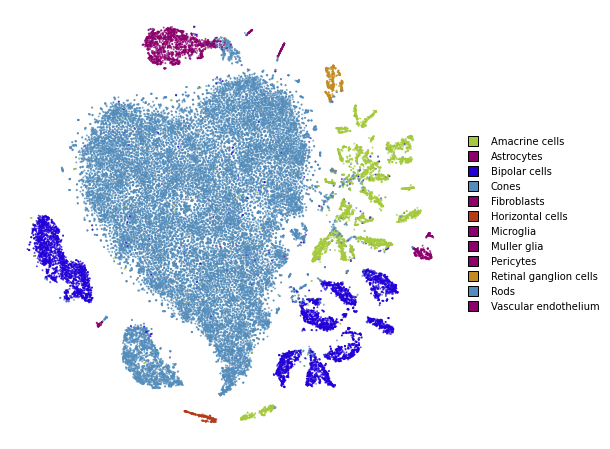

In [6]:
plot(embedding_standard)

### Using PCA initialization

The first, easy improvement we can get is to "inject" some global structure into the initialization. The intialization dictates which regions points will appear in, so adding any global structure to the initilization can help.

Note that this is the default in this implementation and the parameter can be omitted.

In [7]:
%%time
embedding_pca = openTSNE.TSNE(
    perplexity=30,
    initialization="pca",
    metric="euclidean",
    n_jobs=8,
    random_state=3,
).fit(x)

CPU times: user 3min 37s, sys: 3.52 s, total: 3min 40s
Wall time: 2min 1s


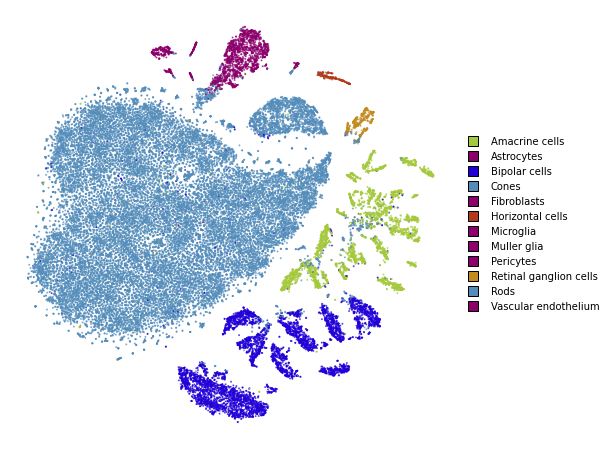

In [8]:
plot(embedding_pca)

### Using cosine distance

Typically, t-SNE is used to create an embedding of high dimensional data sets. However, the notion of *Euclidean* distance breaks down in high dimensions and the *cosine* distance is far more appropriate.

We can easily use the cosine distance by setting the `metric` parameter.

In [9]:
%%time
embedding_cosine = openTSNE.TSNE(
    perplexity=30,
    initialization="random",
    metric="cosine",
    n_jobs=8,
    random_state=3,
).fit(x)

CPU times: user 3min 34s, sys: 2.54 s, total: 3min 37s
Wall time: 1min 51s


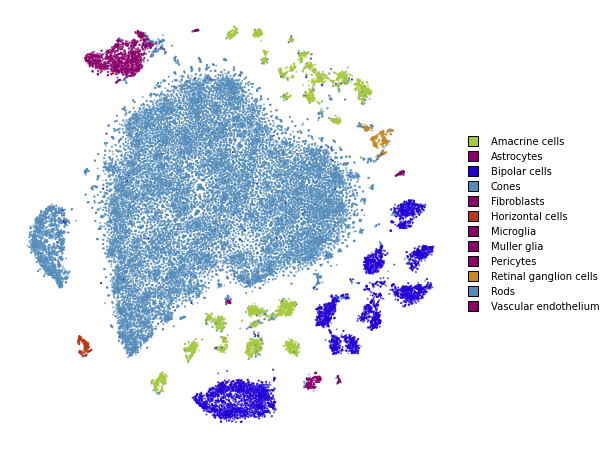

In [10]:
plot(embedding_cosine)

### Using PCA initialization and cosine distance

Lastly, let's see how our embedding looks with both the changes.

In [11]:
%%time
embedding_pca_cosine = openTSNE.TSNE(
    perplexity=30,
    initialization="pca",
    metric="cosine",
    n_jobs=8,
    random_state=3,
).fit(x)

CPU times: user 3min 42s, sys: 3.38 s, total: 3min 45s
Wall time: 2min


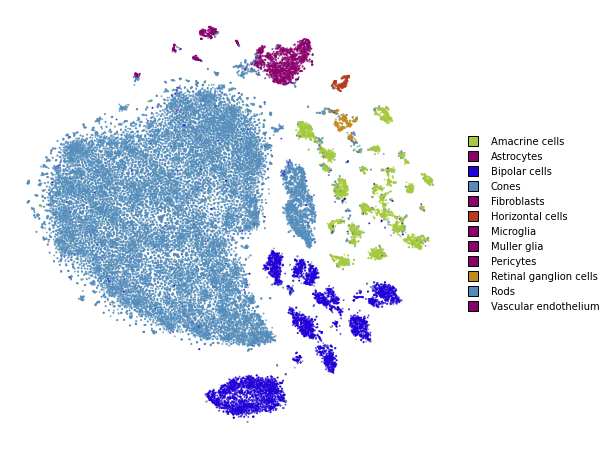

In [12]:
plot(embedding_pca_cosine)

### Summary

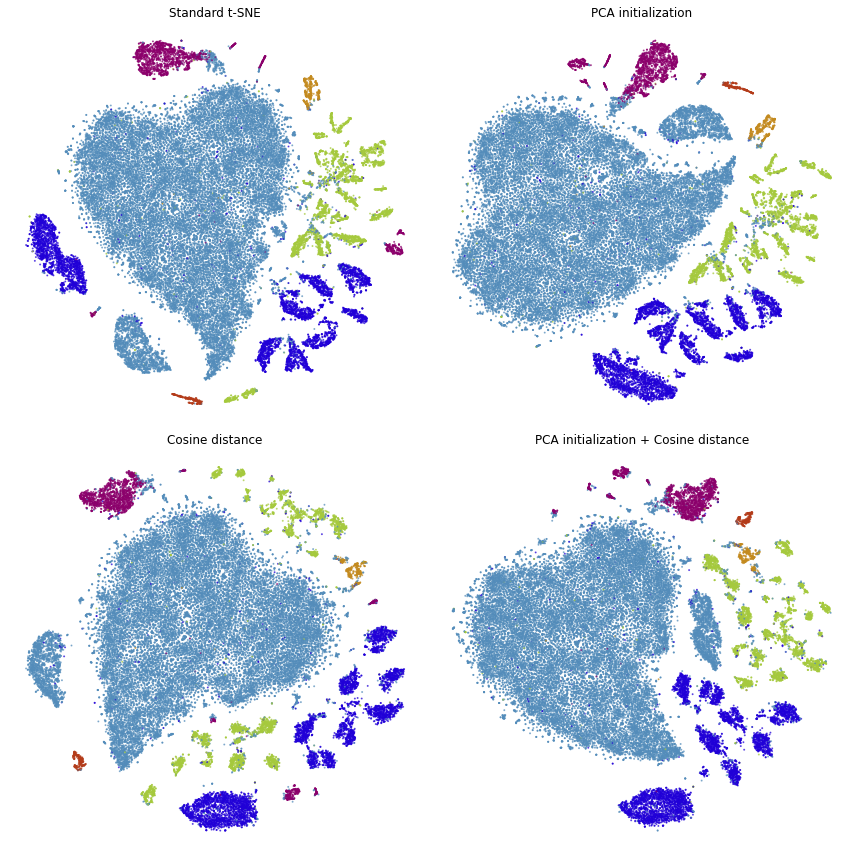

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
plot(embedding_standard, title="Standard t-SNE", ax=ax[0, 0], draw_legend=False)
plot(embedding_pca, title="PCA initialization", ax=ax[0, 1], draw_legend=False)
plot(embedding_cosine, title="Cosine distance", ax=ax[1, 0], draw_legend=False)
plot(embedding_pca_cosine, title="PCA initialization + Cosine distance", ax=ax[1, 1], draw_legend=False)
plt.tight_layout()

We can see that we've made a lot of progress already. We would like points of the same color to appear close to one another.

This is not the case in standard t-SNE and t-SNE with cosine distance, because the green points appear on both the bottom and top of the embedding and the dark blue points appear on both the left and right sides.

This is improved when using PCA initialization and better still when we use both PCA initialization and cosine distance.

## Using perplexity

Perplexity can be thought of as the trade-off parameter between preserving local and global structure. Lower values will emphasise local structure, while larger values will do a better job at preserving global structure.

### Perplexity: 30

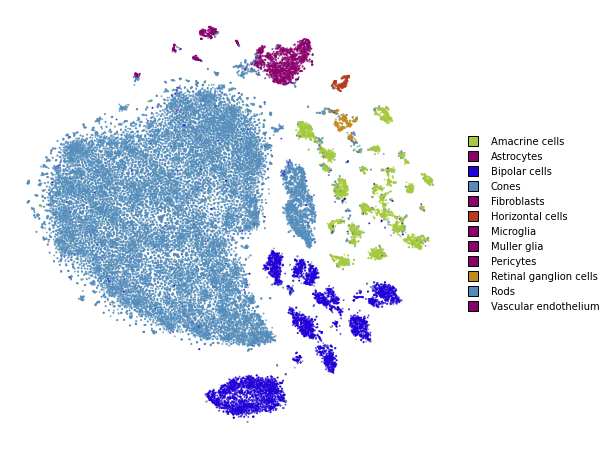

In [14]:
plot(embedding_pca_cosine)

### Perplexity: 500

In [15]:
%%time
embedding_pca_cosine_500 = openTSNE.TSNE(
    perplexity=500,
    initialization="pca",
    metric="cosine",
    n_jobs=8,
    random_state=3,
).fit(x)

CPU times: user 23min 9s, sys: 7.15 s, total: 23min 17s
Wall time: 4min 58s


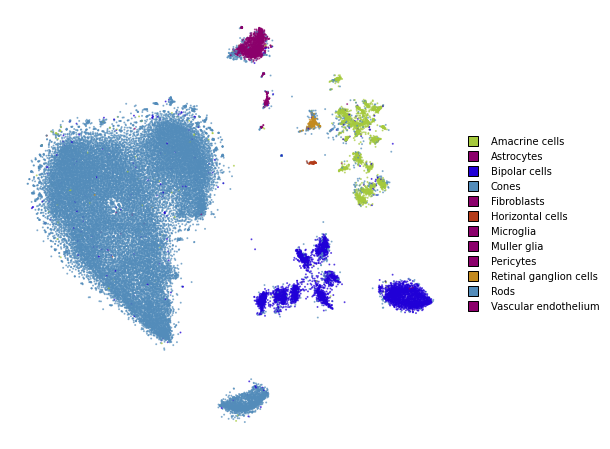

In [16]:
plot(embedding_pca_cosine_500)

## Using different affinity models

We can take advantage of the observation above, and use combinations of perplexities to obtain better embeddings.

In this section, we describe how to use the tricks described by Kobak and Berens in "The art of using t-SNE for single-cell transcriptomics". While the publication focuses on t-SNE applications to single-cell data, the methods shown here are applicable to any data set.

When dealing with large data sets, methods which compute large perplexities may be very slow. Please see the `large_data_sets` notebook for an example of how to obtain a good embedding for large data sets.

### Perplexity annealing

The first trick we can use is to first optimize the embedding using a large perplexity to capture the global structure, then lower the perplexity to something smaller to emphasize the local structure.

In [17]:
%%time
embedding_annealing = openTSNE.TSNE(
    perplexity=500, metric="cosine", initialization="pca", n_jobs=8, random_state=3
).fit(x)

CPU times: user 23min 28s, sys: 6.7 s, total: 23min 35s
Wall time: 5min 1s


In [18]:
%time embedding_annealing.affinities.set_perplexities([50])

CPU times: user 3.35 s, sys: 233 ms, total: 3.59 s
Wall time: 1.33 s


In [19]:
%time embedding_annealing = embedding_annealing.optimize(250)

CPU times: user 1min 26s, sys: 218 ms, total: 1min 26s
Wall time: 46.5 s


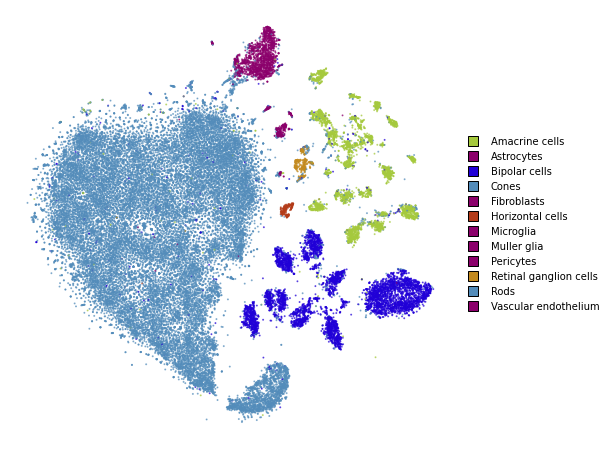

In [20]:
plot(embedding_annealing)

### Multiscale

One problem when using a high perplexity value e.g. 500 is that some of the clusters start to mix with each other, making the separation less apparent. Instead of a typical Gaussian kernel, we can use a multiscale kernel which will account for two different perplexity values. This typically results in better separation of clusters while still keeping much of the global structure.

In [21]:
%%time
affinities_multiscale_mixture = openTSNE.affinity.Multiscale(
    x,
    perplexities=[50, 500],
    metric="cosine",
    n_jobs=8,
    random_state=3,
)

CPU times: user 6min 15s, sys: 8.2 s, total: 6min 23s
Wall time: 1min 23s


In [22]:
%time init = openTSNE.initialization.pca(x, random_state=42)

CPU times: user 1.12 s, sys: 872 ms, total: 1.99 s
Wall time: 349 ms


Now, we just optimize just like we would standard t-SNE.

In [23]:
embedding_multiscale = openTSNE.TSNE(n_jobs=8).fit(
    affinities=affinities_multiscale_mixture,
    initialization=init,
)

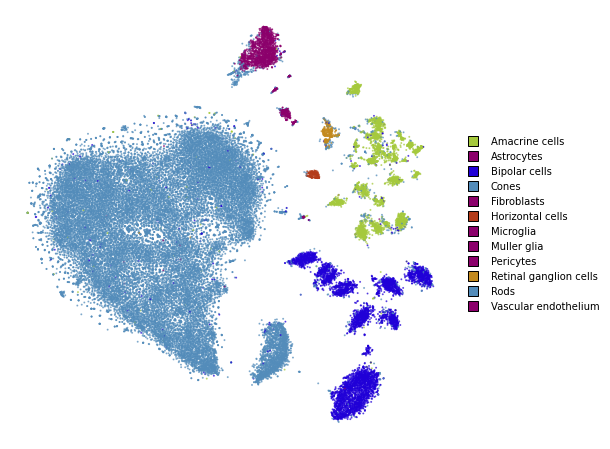

In [24]:
plot(embedding_multiscale)

### Summary

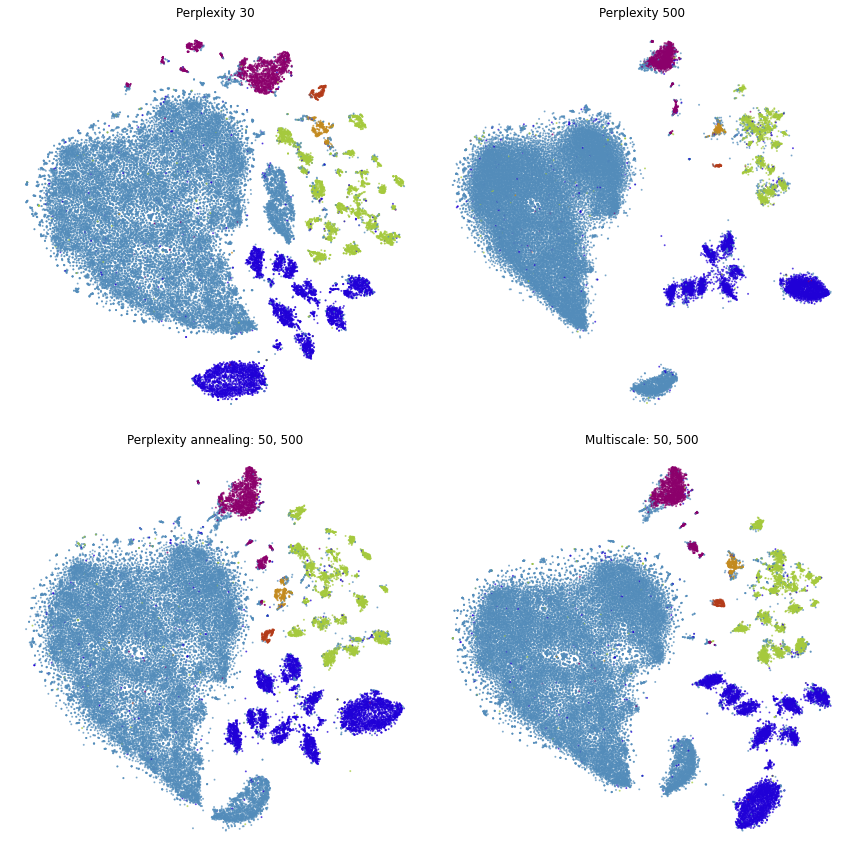

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
plot(embedding_pca_cosine, title="Perplexity 30", ax=ax[0, 0], draw_legend=False)
plot(embedding_pca_cosine_500, title="Perplexity 500", ax=ax[0, 1], draw_legend=False)
plot(embedding_annealing, title="Perplexity annealing: 50, 500", ax=ax[1, 0], draw_legend=False)
plot(embedding_multiscale, title="Multiscale: 50, 500", ax=ax[1, 1], draw_legend=False)
plt.tight_layout()

## Comparison to UMAP

In [26]:
from umap import UMAP
from itertools import product

/home/ppolicar/local/miniconda3/envs/tsne-paper/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
%%time
embeddings = []

for n_neighbors, init in product([15, 200], ["random", "spectral"]):
    umap = UMAP(n_neighbors=n_neighbors, init=init, metric="cosine", random_state=3)
    embedding_umap = umap.fit_transform(x)
    embeddings.append((n_neighbors, init, embedding_umap))

CPU times: user 12min 5s, sys: 53.6 s, total: 12min 58s
Wall time: 6min 34s


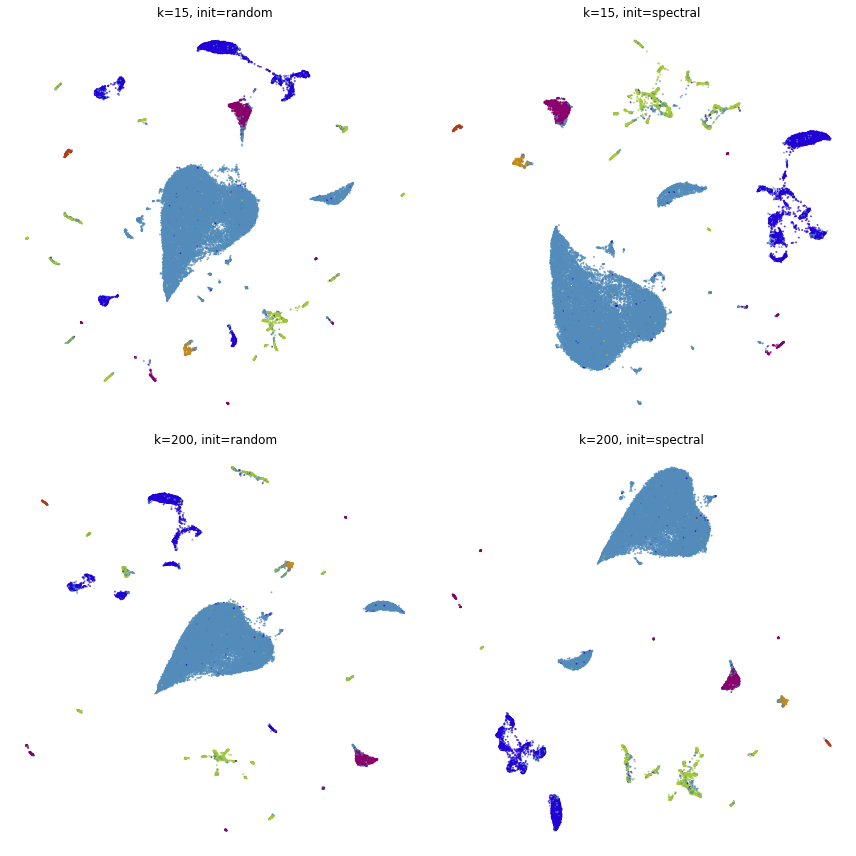

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
plot(embeddings[0][2], title=f"k={embeddings[0][0]}, init={embeddings[0][1]}", ax=ax[0, 0], draw_legend=False)
plot(embeddings[1][2], title=f"k={embeddings[1][0]}, init={embeddings[1][1]}", ax=ax[0, 1], draw_legend=False)
plot(embeddings[2][2], title=f"k={embeddings[2][0]}, init={embeddings[2][1]}", ax=ax[1, 0], draw_legend=False)
plot(embeddings[3][2], title=f"k={embeddings[3][0]}, init={embeddings[3][1]}", ax=ax[1, 1], draw_legend=False)
plt.tight_layout()